# Neuronal Networks
We tried to fit a neuronal network to the scaled (0, 1) data, taking all the predictors (non-zero variance) as input.

After testing a few architecture for the network, we saw that the MSE was highly variable, mostly when changing training/test data, and in a lesser measure when leaving randomness only to the gradient descent process. To tune hyperparameters, we averaged the MSE over multiple predictions based on the same training set for multiple parameter combinations, and tested this approach with different training sets (cross-validation). We could find an optimal tuning that stands for all different training sets, despite the variability of the MSE. We used validation sets combined with early stopping not to overfit. Then, we experimented a bit more on the last most stable conformations to pick the best model.

In [200]:
use_session_with_seed(1)
library(keras)
use_condaenv("r-tensorflow")

data <- read.csv(file.path("..", "data", "training_data.csv"))
data <- na.omit(data)
data$PL <- data$VALENCE.PLEASANTNESS
data$VALENCE.PLEASANTNESS <- NULL
data$SWEETORSOUR <- NULL
data$Intensity <- as.numeric(data$Intensity)

Set session seed to 1 (disabled GPU, CPU parallelism)



In [201]:
cols = names(data[, sapply(data, function(v) var(v) != 0)])
data <- data[,cols]
dim(data)

[1]  708 3029

In [202]:
#training and test response sets
idx <- sample(nrow(data), 4*nrow(data)/5)
    
train.y <- data$PL[idx]
test.y <- data$PL[-idx]

#scaling
data$PL <- NULL
data <- as.matrix(data)

for (i in 1:ncol(data)){
    max <- max(data[,i])
    min <- min(data[,i])
    if (max != 1 & min != 0){
        for (j in 1:nrow(data)) data[j,i] <- (data[j,i]-min) / (max-min)
    }
}

#training and test scaled predictors sets
train.x <- data[idx,]
test.x <- data[-idx,]

The testing of multiple networks (layers, neurons) was easier using a function (with small variants of what is shown):

In [203]:
#create NN with bootstrap data
NN_bs_predict <- function(N1, N2){
    
     nn <- keras_model_sequential() %>%
      layer_dense(units = N1, activation = 'relu', input_shape = c(3028)) %>%
      layer_dense(units = N2, activation = 'relu',) %>%
      layer_dense(units = 1, activation = 'linear')
    
        #train network
        nn %>% compile(
            loss = 'mse',
            optimizer = 'adam'  
        )
        history <- nn %>% fit(
            train.x,
            train.y,
            batch_size = 350, # stochastic gradient descent batch size
            epochs = 650,
            validation_split = 0.25,
            callbacks = callback_early_stopping(monitor = "val_loss", patience = 10)
        )
        y.pred <- predict(nn, test.x) #fixed test set
        MSE <- mean((y.pred - test.y)^2)
        c(MSE, y.pred)
}

In [204]:
res <- NN_bs_predict(600, 100) 

In [205]:
MSE <- res[1]
y.pred <- res[2:length(res)]

In [206]:
paste('MSE = ', MSE)

[1] "MSE =  442.577849422527"

The MSE is sligthly better than lasso regression, but still leaves heavy unprecisions as illustrated in the graph below:

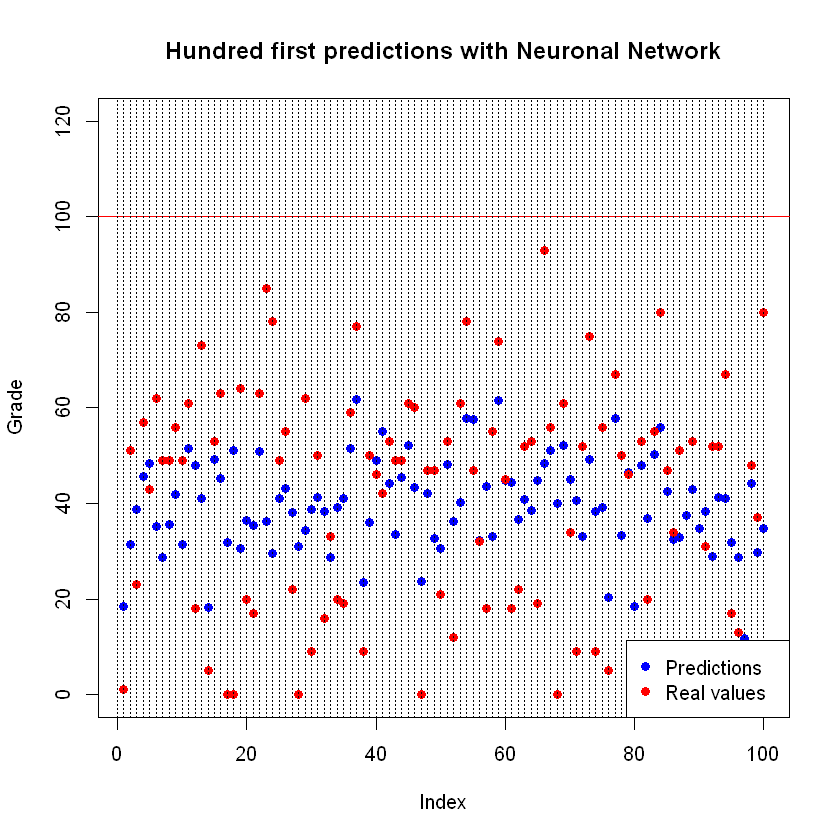

In [207]:
n = 100
plot(y.pred[1:n], col = 'blue', ylab = 'Grade', pch = 19, ylim = c(0, 120))
points(test.y[1:n], col = 'red', pch = 19)
title('Hundred first predictions with Neuronal Network')
abline(h = 100, col = 'red')
for(i in seq(0, n, 1)) abline(v = i, lty = 'dotted')
legend('bottomright', c('Predictions', 'Real values'), col = c('blue', 'red'), pch = 19)

The best improvement compared to linear regression is that the predicted responses are much more spread away from the mean.

# JUSTIFICATION
We demonstrate below how we selected the optimal hyperparameters, given the variability throughout trials on the same training/test sets.
Our conclusions stand when changing training/test sets, because all the MSE change accordingly. However, the model efficiency can change.

In [208]:
each_result <- data.frame(N1_ = 0, N2_ = 0, MSE_ = 0)
mean_MSE <- data.frame(N1_ = 0, N2_ = 0, MSE_ = 0)
mean_predictions_MSE <- data.frame(N1_ = 0, N2_ = 0, MSE_ = 0)


for (N1 in c(1000, 600, 300)){
     for (N2 in c(600, 300, 100)){
         all.y.pred <- matrix(0, nrow = length(test.y), ncol = 5)
         all.MSE <- c()
         for (i in 1:5){
            res_ <- NN_bs_predict(N1, N2)
            MSE <- res_[1]
            y.pred <- res_[2:length(res)]
            each_result <- rbind(each_result, c(N1, N2, MSE))
            all.y.pred[,i] <- y.pred
            all.MSE <- c(all.MSE, MSE)
        }
        mean.y.pred <- rowMeans(all.y.pred)
        mean_pred_MSE <- mean((test.y - mean.y.pred)^2)
        mean_predictions_MSE <- rbind(mean_predictions_MSE, c(N1, N2, mean_pred_MSE))
        mean_MSE <- rbind(mean_MSE, c(N1, N2, mean(all.MSE)))
        
    }
}

In [209]:
print("Individual results on each trial given particular parameters")
print(each_result)

[1] "Individual results on each trial given particular parameters"
    N1_ N2_     MSE_
1     0   0   0.0000
2  1000 600 442.0600
3  1000 600 458.0633
4  1000 600 432.0231
5  1000 600 465.6588
6  1000 600 450.0558
7  1000 300 435.6485
8  1000 300 433.3895
9  1000 300 446.1722
10 1000 300 433.1426
11 1000 300 444.2295
12 1000 100 455.7264
13 1000 100 444.8845
14 1000 100 435.8398
15 1000 100 455.4522
16 1000 100 446.7668
17  600 600 444.0220
18  600 600 435.1616
19  600 600 453.0386
20  600 600 443.0159
21  600 600 453.1548
22  600 300 431.1750
23  600 300 424.4199
24  600 300 445.7199
25  600 300 453.9119
26  600 300 449.0168
27  600 100 425.6810
28  600 100 419.9343
29  600 100 436.1944
30  600 100 437.5911
31  600 100 453.7132
32  300 600 428.2611
33  300 600 452.7226
34  300 600 419.1735
35  300 600 470.0359
36  300 600 418.6643
37  300 300 441.6103
38  300 300 412.9523
39  300 300 457.1860
40  300 300 428.9796
41  300 300 456.5721
42  300 100 491.3665
43  300 100 465.5025
44  300 1

We can observe that the MSE vary quite a lot between the trials for each hyperparameter combination.

In [210]:
print("Mean MSE for each configuration")
print(mean_MSE)

[1] "Mean MSE for each configuration"
    N1_ N2_     MSE_
1     0   0   0.0000
2  1000 600 449.5722
3  1000 300 438.5164
4  1000 100 447.7339
5   600 600 445.6786
6   600 300 440.8487
7   600 100 434.6228
8   300 600 437.7715
9   300 300 439.4600
10  300 100 464.9520


However, when averaging the MSE, we conclude that the most reasonable conformation is with N1 = 600, N2 = 100. Changing the training/test sets does not alter that conclusion.

In [211]:
print("Mean result for each hyperparameters combination")
print(mean_predictions_MSE)

[1] "Mean result for each hyperparameters combination"
    N1_ N2_     MSE_
1     0   0   0.0000
2  1000 600 436.8268
3  1000 300 423.1996
4  1000 100 435.4447
5   600 600 434.9533
6   600 300 426.1570
7   600 100 426.1058
8   300 600 423.9941
9   300 300 428.5476
10  300 100 448.7655


As additional information, we observe that averaging the different predictions lowers the MSE for every configuration, probably due to the fact the the response seem normally distributed around the middle to some extent.